In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, RocCurveDisplay, f1_score, PrecisionRecallDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture

## Read data

In [124]:
df = pd.read_csv('./data_normalized.csv')
df.describe()

,service,flag,src_bytes,dst_bytes,count,same_srv_rate,diff_srv_rate,dst_host_srv_count,dst_host_srv_serror_rate,dst_host_diff_srv_rate,target
count,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000
mean,0.071348,0.015751,0.309399,0.619847,0.109832,0.001831,0.000147,0.242860,0.000258,0.000262,0.121434
std,0.118820,0.029258,0.330254,0.401061,0.286767,0.003944,0.001319,0.276639,0.001429,0.001639,0.326632
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.009058,0.003370,0.036919,0.192810,0.001166,0.000274,0.000000,0.043423,0.000000,0.000000,0.000000
50%,0.029068,0.007121,0.166901,0.808332,0.004606,0.000746,0.000000,0.124025,0.000000,0.000000,0.000000
75%,0.057431,0.017376,0.498051,0.987501,0.018201,0.001890,0.000000,0.358505,0.000000,0.000035,0.000000
max,0.999427,0.601248,1.000000,1.000000,0.999862,0.218218,0.240772,0.997373,0.081650,0.240772,1.000000


In [125]:
print(df['target'].value_counts())

0    206854
1     28591
Name: target, dtype: int64


## Split data 
In this part, we are trying to conduct novelty detection, which is a kind of anomaly detection: https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection
Use normal data as the training data, and abnormal data + normal data as the testing data

In [126]:
# get normal and abnormal data in df
y_normal = df[df['target'] == 0]['target']
X_normal = df[df['target'] == 0].drop(['target'], axis=1, inplace=False)

y_attack = df[df['target'] == 1]['target']
X_attack = df[df['target'] == 1].drop(['target'], axis=1, inplace=False)

# 70% normal only data for training
X_train, X_left_normal, y_train, y_left_normal = train_test_split(X_normal, y_normal, test_size=0.3, random_state=42)

# 15% normal + 50% attack data for valid, 15% normal + 50% attack data for testing
X_valid_normal, X_test_normal, y_valid_normal, y_test_normal = train_test_split(X_left_normal, y_left_normal, test_size=0.5)
X_valid_attack, X_test_attack, y_valid_attack, y_test_attack = train_test_split(X_attack, y_attack, test_size=0.5)

# # # prepare data for valid, testing
X_valid = pd.concat([X_valid_normal, X_valid_attack])
y_valid = pd.concat([y_valid_normal, y_valid_attack])

X_test = pd.concat([X_test_normal, X_test_attack])
y_test = pd.concat([y_test_normal, y_test_attack])

## Anomaly Detection (Nearest Neighbor)

In [127]:
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(X_train)
distances, _ = neigh.kneighbors(X_valid)

In [128]:
distances_ = pd.Series([dist[0] for dist in distances])
label_distances = pd.DataFrame({'label': y_valid, 'distance': distances_})
max_dist = label_distances.groupby('label')['distance'].max()

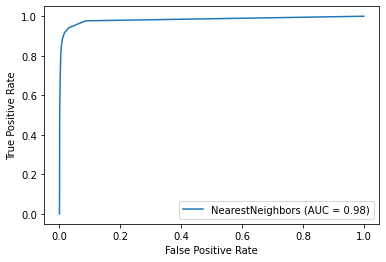

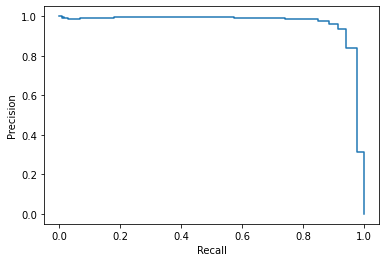

In [129]:
interval = (max_dist[1] - 0)/50
thresholds = np.arange(0, max_dist[1], interval)

FPR, TPR = [], []
recall, precision, F1 = [1], [0], []
pred_list = []

for thres in thresholds:
    pred = distances_.copy()
    pred[pred>=thres] = 1
    pred[pred<thres] = 0
    tn, fp, fn, tp = confusion_matrix(y_valid, pred).ravel()
    fpr = (fp)/(fp+tn)
    tpr = (tp)/(tp+fn)
    FPR.append(fpr)
    TPR.append(tpr)
    rec = recall_score(y_valid, pred)
    prec = precision_score(y_valid, pred)
    recall.append(rec)
    precision.append(prec)
#     print(f"When threshold = {thres:.5f}, FPR: {fpr:.5f}  TPR: {tpr:.5f}, recall: {rec}, precision: {prec}")
    F1.append(f1_score(y_valid, pred))
    pred_list.append(pred)

FPR.append(0)
TPR.append(0)
roc_auc = auc(FPR, TPR)
display = RocCurveDisplay(fpr=FPR, tpr=TPR, roc_auc=roc_auc, estimator_name='NearestNeighbors')
display.plot()
plt.show()

recall.append(0)
precision.append(1)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

The max f1 is: 0.9389085957934717
The best threshold is: 0.01554879389725812


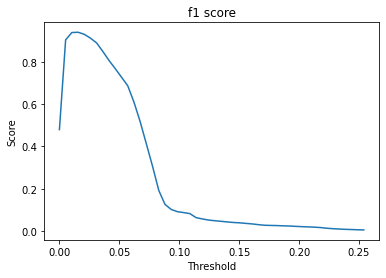

In [130]:
f1_max = np.array(F1).max()
print(f"The max f1 is: {f1_max}")
best_thres = thresholds[np.array(F1).argmax()]
print(f"The best threshold is: {best_thres}")
plt.plot(thresholds, F1)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("f1 score")
plt.show()

In [131]:
def print_metrics(model_name, y_test, y_pred):
    print()
    print(f"============================== {model_name} Model Evaluation ==============================")
    print()
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print ("Model Accuracy:" "\n", accuracy)
    print()
    classification = metrics.classification_report(y_test, y_pred)
    print("Classification report:" "\n", classification) 
    print()
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=[0, 1], display_labels=['Normal', 'Abormal'])
    # remove grid lines
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.grid(visible=None)
    plt.show()


============================== NearestNeighbor Model Evaluation ==============================

Model Accuracy:
 0.9627137341423055

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     31029
           1       0.96      0.92      0.94     14296

    accuracy                           0.96     45325
   macro avg       0.96      0.95      0.96     45325
weighted avg       0.96      0.96      0.96     45325




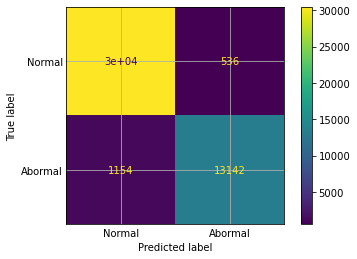

In [132]:
distances, _ = neigh.kneighbors(X_test)
distances_ = pd.Series([dist[0] for dist in distances])

y_pred = distances_.copy()
y_pred[y_pred>=best_thres] = 1
y_pred[y_pred<best_thres] = 0

print_metrics("NearestNeighbor", y_test, y_pred)

## Anomaly Detection (Gussian Mixture Model)

In [133]:
gmm = [GaussianMixture(n_components=i).fit(X_train) for i in [1,2,3]]

ave_score = []
for i in range(3):
    valid_normal_score = gmm[i].score(X_valid_normal)
    valid_attack_score = gmm[i].score(X_valid_attack)
    ave_score.append((valid_attack_score, valid_normal_score))

    print(valid_normal_score)
    print(valid_attack_score)

26.668523056629507
-84.13013796433022
35.44204567920885
-23.457402866498438
37.38420729809428
-5.687822630455868


The max f1 is: 0.9028549676437
The best threshold is: -59.13013796433022
The max f1 is: 0.9031522111106888
The best threshold is: -5.4574028664984375
The max f1 is: 0.8649735783579146
The best threshold is: -0.6878226304558677


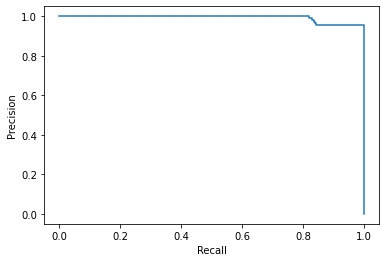

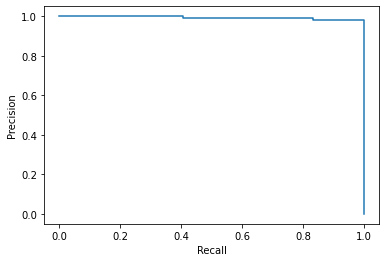

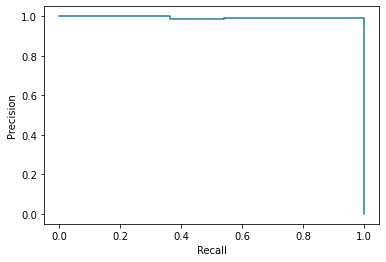

In [134]:
best_thres_list = []
for i in range(3):
    thresholds = np.arange(ave_score[i][0], ave_score[i][1], 1)

    precision, recall, f1 = [1], [0], []
    FPR, TPR = [0], [0]

    for thres in thresholds:
        valid_ss = gmm[i].score_samples(X_valid)
        pred = valid_ss.copy()
        pred[pred>=thres] = 0
        pred[pred<thres] = 1
        tn, fp, fn, tp = confusion_matrix(y_valid, pred).ravel()
        fpr = (fp)/(fp+tn)
        tpr = (tp)/(tp+fn)
        FPR.append(fpr)
        TPR.append(tpr)
        rec = recall_score(y_valid, pred)
        prec = precision_score(y_valid, pred)
#         print(f"When threshold = {thres:.5f}, fpr: {fpr:.5f}, tpr: {tpr:.5f}, recall: {rec:.5f}  precision: {prec:.5f}")
        recall.append(rec)
        precision.append(prec)
        f1.append(f1_score(y_valid, pred))

    recall.append(1)
    precision.append(0)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    
    f1_max = np.array(f1).max()
    print(f"The max f1 is: {f1_max}")
    best_thres = thresholds[np.array(f1).argmax()]
    print(f"The best threshold is: {best_thres}")
    best_thres_list.append(best_thres)


============================== GMM Model Evaluation ==============================

Model Accuracy:
 0.9452840595697739

Classification report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     31029
           1       0.99      0.83      0.91     14296

    accuracy                           0.95     45325
   macro avg       0.96      0.92      0.93     45325
weighted avg       0.95      0.95      0.94     45325




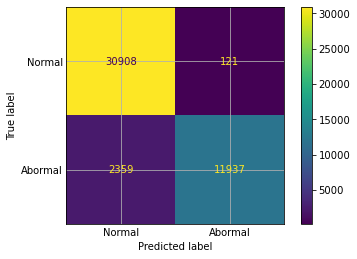


============================== GMM Model Evaluation ==============================

Model Accuracy:
 0.9455488141202427

Classification report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     31029
           1       0.99      0.84      0.91     14296

    accuracy                           0.95     45325
   macro avg       0.96      0.92      0.93     45325
weighted avg       0.95      0.95      0.94     45325




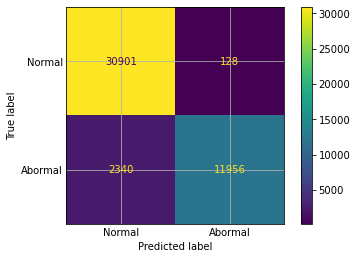


============================== GMM Model Evaluation ==============================

Model Accuracy:
 0.9241257584114727

Classification report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     31029
           1       0.99      0.77      0.86     14296

    accuracy                           0.92     45325
   macro avg       0.95      0.88      0.91     45325
weighted avg       0.93      0.92      0.92     45325




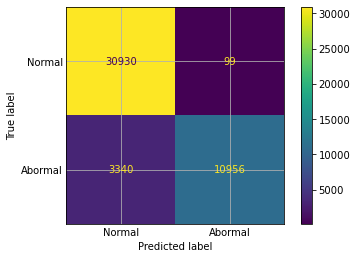

In [135]:
for i in range(3):
    test_ss = gmm[i].score_samples(X_test)
    test_pred = test_ss.copy()

    best_thres = best_thres_list[i]
    
    test_pred[test_pred>=best_thres] = 0
    test_pred[test_pred<best_thres] = 1

    print_metrics("GMM", y_test, test_pred)

## Misuse Detection (Machine Learning Algorithms)

In [136]:
df = pd.read_csv('./data_normalized.csv')
df.describe()

,service,flag,src_bytes,dst_bytes,count,same_srv_rate,diff_srv_rate,dst_host_srv_count,dst_host_srv_serror_rate,dst_host_diff_srv_rate,target
count,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000
mean,0.071348,0.015751,0.309399,0.619847,0.109832,0.001831,0.000147,0.242860,0.000258,0.000262,0.121434
std,0.118820,0.029258,0.330254,0.401061,0.286767,0.003944,0.001319,0.276639,0.001429,0.001639,0.326632
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.009058,0.003370,0.036919,0.192810,0.001166,0.000274,0.000000,0.043423,0.000000,0.000000,0.000000
50%,0.029068,0.007121,0.166901,0.808332,0.004606,0.000746,0.000000,0.124025,0.000000,0.000000,0.000000
75%,0.057431,0.017376,0.498051,0.987501,0.018201,0.001890,0.000000,0.358505,0.000000,0.000035,0.000000
max,0.999427,0.601248,1.000000,1.000000,0.999862,0.218218,0.240772,0.997373,0.081650,0.240772,1.000000


In [137]:
# get normal and abnormal data in df
y_normal = df[df['target'] == 0]['target']
X_normal = df[df['target'] == 0].drop(['target'], axis=1, inplace=False)

y_attack = df[df['target'] == 1]['target']
X_attack = df[df['target'] == 1].drop(['target'], axis=1, inplace=False)

# split data into train and test
# 70% normal data for training, 30% attack data for testing
X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(X_normal, y_normal, test_size=0.3, random_state=42)

# 70% attack data for training, 30% attack data for testing
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(X_attack, y_attack, test_size=0.3, random_state=42)

# # # prepare data for train and test set
X_train = pd.concat([X_train_normal, X_train_attack])
y_train = pd.concat([y_train_normal, y_train_attack])

X_test = pd.concat([X_test_normal, X_test_attack])
y_test = pd.concat([y_test_normal, y_test_attack])

In [138]:
def train_classifier(models, X_train, y_train, X_test, y_test):
    model_name, model = models
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = cross_val_score(model, X_train, y_train, cv=10)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    classification = metrics.classification_report(y_test, y_pred)
    print()
    print(f"============================== {model_name} Model Evaluation ==============================")
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Classification report:" "\n", classification) 
    print()
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=[0, 1], display_labels=['Normal', 'Abnormal'])
    # remove grid lines
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.grid(visible=None)
    plt.show()
    return accuracy


In [139]:
# function to plot roc curve
def plot_kfold_roc_curve(classifier,X,y,title):

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=5)

    # defining the lists
    tprs = []
    aucs = []
    f1s = []
    mean_fpr = np.linspace(0, 1, 100)
    
    fig, ax = plt.subplots(figsize=(8,6))
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X.iloc[train], y.iloc[train].values.ravel())
        # Compute ROC curve and area under the curve (roc/auc)
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X.iloc[test],
            y.iloc[test],
            name=f"ROC fold {i}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        y_pred = classifier.predict(X.iloc[test])
        f1s.append(f1_score(y_true = y.iloc[test],y_pred = y_pred))
    print(f"average f1 score is: {sum(f1s)/len(f1s)}")
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=title,
    )
    ax.legend(loc="lower right")
    plt.show()
    

In [140]:
# function to plot prc curve

def plot_prc_curve(classifier, X, y, title, n_folds = 5):
    
    cv = StratifiedKFold(n_splits = n_folds)    

    # defining the lists
    prs = []
    aucs = []
    mean_recall = np.linspace(0, 1, 100)
    f1s = []
    
    plt.figure(figsize=(8 , 6))
    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train].values.ravel()).predict_proba(X.iloc[test])
        # Compute PR curve and area the curve
        precision, recall, thresholds = precision_recall_curve(y.iloc[test], probas_[:, 1])
        prs.append(np.interp(mean_recall, precision, recall))
        pr_auc = auc(recall, precision)
        aucs.append(pr_auc)
        
        #compute f1 score
        y_pred = classifier.predict(X.iloc[test])
        f1s.append(f1_score(y_true = y.iloc[test],y_pred = y_pred))
        
        plt.plot(recall, precision, lw=1, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))
        i += 1
    
    plt.plot([0, 1], [1, 0], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    mean_precision = np.mean(prs, axis=0)
    mean_auc = auc(mean_recall, mean_precision)
    std_auc = np.std(aucs)
    print("Average f1 score is: %f" % (sum(f1s)/len(f1s)))
    plt.plot(mean_precision, mean_recall, color='b',
             label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2)
    

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall' )
    plt.ylabel('Precision')
    plt.title(title)
#     plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend(loc = "lower left")
    plt.show()

### K Nearest Neighbors


============================== KNN Model Evaluation ==============================

Cross Validation Mean Score:
 0.9971664340756021

Model Accuracy:
 0.9974092163941389

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     62057
           1       1.00      0.98      0.99      8578

    accuracy                           1.00     70635
   macro avg       1.00      0.99      0.99     70635
weighted avg       1.00      1.00      1.00     70635




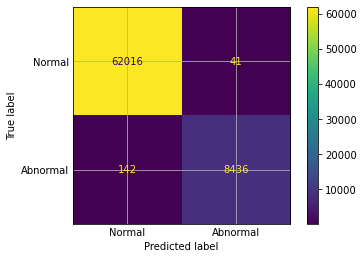


============================== KNN Model Evaluation ==============================

Cross Validation Mean Score:
 0.9971603664826162

Model Accuracy:
 0.9975932611311673

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     62057
           1       0.99      0.99      0.99      8578

    accuracy                           1.00     70635
   macro avg       0.99      0.99      0.99     70635
weighted avg       1.00      1.00      1.00     70635




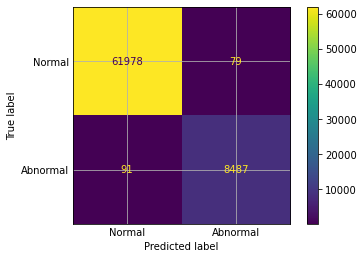


============================== KNN Model Evaluation ==============================

Cross Validation Mean Score:
 0.9969662035070688

Model Accuracy:
 0.9972676435195017

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     62057
           1       0.99      0.98      0.99      8578

    accuracy                           1.00     70635
   macro avg       1.00      0.99      0.99     70635
weighted avg       1.00      1.00      1.00     70635




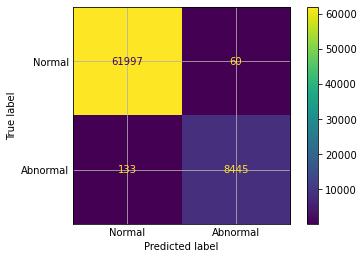


============================== KNN Model Evaluation ==============================

Cross Validation Mean Score:
 0.9968630544263091

Model Accuracy:
 0.9972251716571104

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     62057
           1       0.99      0.99      0.99      8578

    accuracy                           1.00     70635
   macro avg       0.99      0.99      0.99     70635
weighted avg       1.00      1.00      1.00     70635




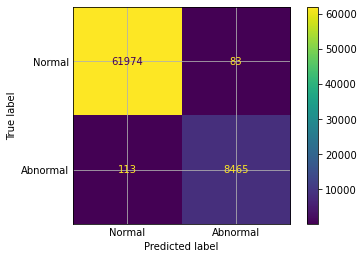


============================== KNN Model Evaluation ==============================

Cross Validation Mean Score:
 0.9967174321946484

Model Accuracy:
 0.9969278686203723

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     62057
           1       0.99      0.98      0.99      8578

    accuracy                           1.00     70635
   macro avg       0.99      0.99      0.99     70635
weighted avg       1.00      1.00      1.00     70635




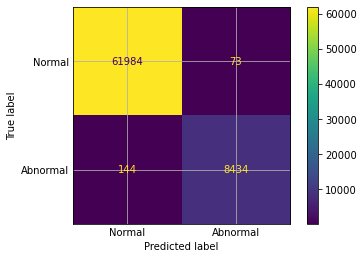


============================== KNN Model Evaluation ==============================

Cross Validation Mean Score:
 0.9965900127419453

Model Accuracy:
 0.9968712394705175

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     62057
           1       0.99      0.98      0.99      8578

    accuracy                           1.00     70635
   macro avg       0.99      0.99      0.99     70635
weighted avg       1.00      1.00      1.00     70635




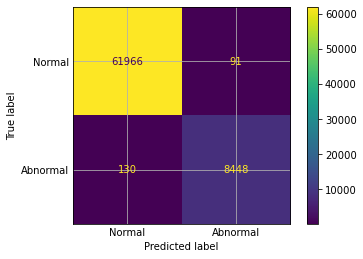


============================== KNN Model Evaluation ==============================

Cross Validation Mean Score:
 0.9964140525453555

Model Accuracy:
 0.996588093721243

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     62057
           1       0.99      0.98      0.99      8578

    accuracy                           1.00     70635
   macro avg       0.99      0.99      0.99     70635
weighted avg       1.00      1.00      1.00     70635




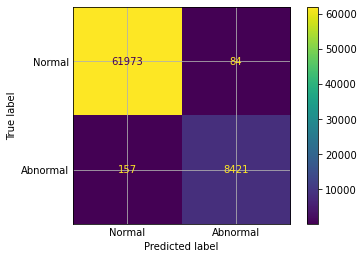


============================== KNN Model Evaluation ==============================

Cross Validation Mean Score:
 0.9962380923487653

Model Accuracy:
 0.9964465208466058

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     62057
           1       0.99      0.98      0.99      8578

    accuracy                           1.00     70635
   macro avg       0.99      0.99      0.99     70635
weighted avg       1.00      1.00      1.00     70635




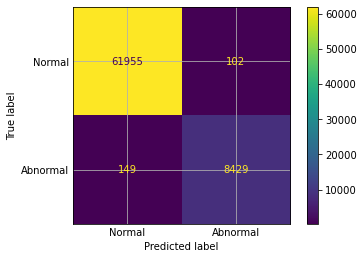


============================== KNN Model Evaluation ==============================

Cross Validation Mean Score:
 0.9960924701171047

Model Accuracy:
 0.9963615771218235

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     62057
           1       0.99      0.98      0.98      8578

    accuracy                           1.00     70635
   macro avg       0.99      0.99      0.99     70635
weighted avg       1.00      1.00      1.00     70635




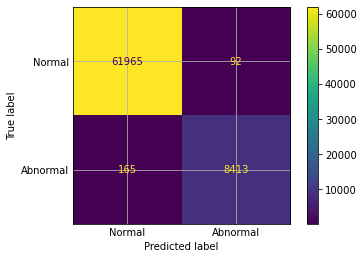

the best parameter k: 3


In [142]:
from sklearn.neighbors import KNeighborsClassifier

acry_list = []
k_list = range(2,11)
for k in k_list:
    accuracy = train_classifier(("KNN", KNeighborsClassifier(n_neighbors=k)), X_train, y_train, X_test, y_test)
    acry_list.append(accuracy)
    
idx = acry_list.index(max(acry_list))
best_k = list(k_list)[idx]
print(f"the best parameter k: {best_k}")

Average f1 score is: 0.942440


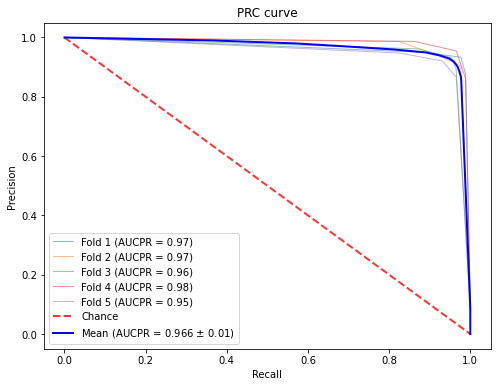

In [122]:
classifier = KNeighborsClassifier(n_neighbors=best_k)
X2 = X.iloc[:5000, :]
y2 = y.iloc[:5000]
plot_prc_curve(classifier, X2, y2, title = "PRC curve")